In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

In [2]:
def dim_matrix(matrix):
    return len(matrix),len(matrix[0])

def diag_to_matrix(array):
    length = len(array)
    matrix = np.zeros([length,length])

    for row in range(0, length):
        matrix[row][row] = array[row]

    return matrix

In [3]:
data  = pd.read_excel( "C:/Users/michelj8/Documents/GitHub/Dynamic-MESS/test_data.xlsx")
region_names = ['A','B','C','D','E']
data.head()

,GeoName,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A,0.763041,0.613304,1.010560,1.335926,1.227371,1.236897,1.760362,1.779145,1.502699,...,1.797913,1.708885,2.068604,2.236400,1.707694,1.859276,1.776400,2.071460,1.881300,1.721234
1,B,0.121442,0.758527,0.840336,1.460023,1.459809,1.014948,1.217272,1.738741,2.090783,...,2.121304,1.413151,1.842288,1.504895,1.453550,1.856370,1.504546,1.793134,2.136047,1.802515
2,C,0.897191,0.688994,0.819422,1.043065,1.376121,1.142730,1.148341,1.285991,1.214368,...,0.905318,1.011163,1.062949,1.598621,1.982707,2.249975,1.853039,1.604357,1.476063,1.265674
3,D,0.883783,1.564482,1.949984,1.977637,1.329059,1.178102,1.099520,1.009249,1.671471,...,2.108700,1.783046,2.019192,1.752922,2.079098,2.381718,1.887941,1.757791,1.309714,1.491567
4,E,0.970681,0.935181,0.797022,0.630667,0.735882,1.162991,1.129236,1.009160,0.974439,...,1.799736,1.335444,0.960245,1.338912,1.716879,2.066515,2.139327,1.969188,2.227908,2.439112


In [12]:
region_data = data[data['GeoName'].isin(region_names)].copy()
# region_data = region_data[ region_data['Description'] == 'Total employment (number of jobs)']

region_data = region_data.set_index('GeoName')
year_list = range(1,21)

region_data = region_data[year_list]
region_data
dynamic_spatial_data =region_data.copy()

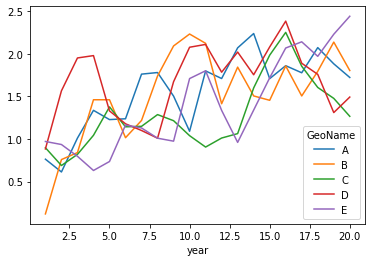

In [13]:
region_data_long = region_data.reset_index().melt( id_vars=['GeoName'], var_name='year', value_name = 'value')
region_data_long['value'] = region_data_long['value'].astype(float)
region_data = pd.pivot_table( region_data_long, index = 'year', columns = 'GeoName' , values = 'value')

region_data.plot()

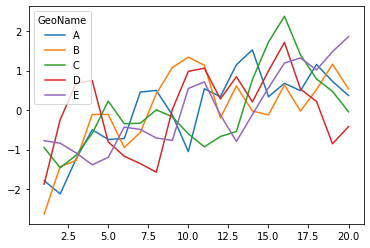

In [14]:
spatial_df = dynamic_spatial_data.copy()

series_means = spatial_df.mean(axis = 1)
normalized_spatial_df = spatial_df.copy()
normalized_spatial_df = normalized_spatial_df.sub(series_means, axis = 0)
series_sd = normalized_spatial_df.std(axis = 1)
normalized_spatial_df = normalized_spatial_df.div(series_sd, axis = 0)
year_list = normalized_spatial_df.columns

pd.pivot_table( normalized_spatial_df.reset_index(), columns = 'GeoName').plot()

## Choices for weight matrix here: VAR based weights (correlations),  geography, and uniform

In [15]:
# #Matrix coming from a VAR specification
# #VAR analysis on the normalized dataset
norm_means = delta_region_data.mean(axis =0)
norm_delta_region = delta_region_data.sub(norm_means, axis =1)

norm_sd = norm_delta_region.std(axis =0)
norm_delta_region = norm_delta_region.div(norm_sd, axis =1)

model = VAR(delta_region_data).fit()
# model = VAR(norm_delta_region).fit()

var_matrix = model.params
mod_region_names = ['L1.'+x for x in region_names]
var_matrix = var_matrix.loc[mod_region_names][region_names].values

def max_zero(x):
    return max(x,0.0)

var_weight_matrix = np.vectorize(max_zero)(var_matrix) 
for ind in range(0,len(var_weight_matrix)):
    var_weight_matrix[ind,ind] =0
    
var_weight_matrix = pd.DataFrame(var_weight_matrix)
var_weight_matrix
var_weight_matrix = var_weight_matrix.div( var_weight_matrix.sum(axis = 1), axis = 0)
var_weight_matrix = var_weight_matrix.fillna(0)
var_weight_matrix = var_weight_matrix.values

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [16]:
# # #Weight matrix based on adjacent neighbors
# map_weight_matrix = np.zeros([8,8])

# map_weight_matrix[0,1] = 1.0
# map_weight_matrix[1,[0,2,4]] = 1.0/3.0
# map_weight_matrix[2,[1,3,4]] = 1.0/3.0
# map_weight_matrix[3,[2,4,5,6]] = 1.0/4.0
# map_weight_matrix[4,[1,2,3,5]] = 1.0/4.0
# map_weight_matrix[5,[3,4,6,7]] = 1.0/4.0
# map_weight_matrix[6,[3,5,7]] = 1.0/3.0
# map_weight_matrix[7,[5,6]] = 1.0/2.0

In [20]:
unif_weight_matrix = np.ones([len(dynamic_spatial_data), len(dynamic_spatial_data)])
unif_weight_matrix = unif_weight_matrix/len(dynamic_spatial_data)

for ind in range(0,len(unif_weight_matrix)):
    unif_weight_matrix[ind,ind] =0

# Define the forecasting functions here

In [21]:
def forecast_k_ahead(theta, k, spatial_df, w_matrix):
    no_series = len(spatial_df)
    
    #In this section we normalize the data to be forecasted, giving it mean 0 and s.d. 1
    series_means = spatial_df.mean(axis = 1)
    normalized_spatial_df = spatial_df.copy()
    normalized_spatial_df = normalized_spatial_df.sub(series_means, axis = 0)
    series_sd = normalized_spatial_df.std(axis = 1)
    normalized_spatial_df = normalized_spatial_df.div(series_sd, axis = 0)
    
#     alpha = np.array(theta[0:8]).reshape([8,1])
    rho = theta[0]
    phi = theta[1]
    lam = theta[2]
    
    id_matrix = diag_to_matrix(no_series*[1])
    aux_matrix = rho* id_matrix + phi * w_matrix
    s_matrix = id_matrix - lam*w_matrix
    
    s_inv_matrix = np.linalg.inv(s_matrix)
    m_theta_matrix = np.dot(s_inv_matrix, aux_matrix)
    
    forecast_array = normalized_spatial_df.copy()
    for k_ahead in range(0,k):
#         forecast_array = np.dot(s_inv_matrix,alpha) + np.dot(m_theta_matrix, forecast_array)
        forecast_array = np.dot(m_theta_matrix, forecast_array)

    forecast_df = pd.DataFrame(forecast_array)
    forecast_df['region'] = region_names
    forecast_df = forecast_df.set_index('region')
    forecast_df = forecast_df.mul(series_sd, axis =0).add(series_means, axis =0 )
    forecast_df.columns = spatial_df.columns + k
    
    return forecast_df

In [22]:
def forecast_errors_k_ahead(theta,k, spatial_df, w_matrix):
    forecast_df = forecast_k_ahead(theta,k,spatial_df,w_matrix)
    
    data_years = list(spatial_df.columns)
    forecast_years = list(forecast_df.columns)
    overlap_years = [x for x in data_years if x in forecast_years]
    
    errors = forecast_df[overlap_years]-spatial_df[overlap_years]
    return errors

In [23]:
def sse_k_ahead(theta,k,spatial_df, w_matrix):
    error_df = forecast_errors_k_ahead(theta,k,spatial_df,w_matrix)
    return np.square(error_df).sum().sum()

In [26]:
import itertools
first_year = 1
last_year_out = 20
k = 1
weight_matrix = unif_weight_matrix

def data_sse_k_ahead(theta,k,min_year, max_year,w_matrix):
    return sse_k_ahead(theta,k,dynamic_spatial_data[range(min_year,max_year)], w_matrix)

min_theta = [0,0,0]
min_errors = data_sse_k_ahead(min_theta,k,first_year, last_year_out, weight_matrix)

rho_grid = np.linspace(0,.7,10)
phi_grid = np.linspace(0,.5,10)
lam_grid = np.linspace(0,.5,10)

for theta in itertools.product(rho_grid, phi_grid, lam_grid):
    errors = data_sse_k_ahead(theta,k,first_year, last_year_out, weight_matrix)
    if errors < min_errors:
        min_theta = theta
        min_errors = errors
        
print(min_theta)
print( sse_k_ahead(min_theta,1,dynamic_spatial_data,weight_matrix ) )
print( sse_k_ahead([0,0,0],1,dynamic_spatial_data,weight_matrix ) )

(0.5444444444444445, 0.0, 0.38888888888888884)
7.973478542326932
17.933539849458043


In [28]:
from statsmodels.tsa.arima_model import ARMA

ar_df = pd.DataFrame(columns = ['alpha','rho'])
sse = 0

for region in region_names:
    region_series = dynamic_spatial_data.loc[region].values
    model = ARMA(region_series, (1,0)).fit()
    ar_df.loc[region] = model.params
    sse = sse + np.square(region_series - model.predict()).sum()
    
print(sse)

11.383553608323686


In [29]:
ar_df

,alpha,rho
A,1.485991,0.745577
B,1.365970,0.790076
C,1.226858,0.794977
D,1.602845,0.601590
E,1.529116,0.878227


In [30]:
model = VAR(delta_region_data).fit()
model.params

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


,A,B,C,D,E
const,0.0,0.0,0.0,0.0,0.0
L1.A,0.0,0.0,0.0,0.0,0.0
L1.B,0.0,0.0,0.0,0.0,0.0
L1.C,0.0,0.0,0.0,0.0,0.0
L1.D,0.0,0.0,0.0,0.0,0.0
L1.E,0.0,0.0,0.0,0.0,0.0


In [31]:
np.square(model.resid).sum().sum()

0.0